In [3]:
# Part 1

import datetime
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt

start_date = datetime.datetime(2019, 1, 1)
end_date = datetime.datetime(2020, 1, 1)
ticker_list = ["AAPL", "F", "FB", "XOM"]

stock_data = pdr.DataReader(ticker_list, "yahoo", start_date, end_date)

prices = stock_data['Adj Close']

rets = prices.pct_change().dropna()

In [13]:
T = 100 # How long is our simulation? Let's do 100 days.
N = 100 # number of time points in the prediction time horizon, making this the same as T means that we will simulate daily returns 
dt = T/N # daily steps
noa = 4 # Number of assets

weights = np.array(noa * [1. / noa,])  # EW portfolio based on number of assets. You can change this array to have any weights you want.

mu = rets.mean()
cov = rets.cov()
sigma = rets.std()
corr = rets.corr()

port_returns_all = np.full((T-1, N_SIM), 0.) # One less return than price

S_0 = prices.iloc[-1]
A = np.linalg.cholesky(cov)
S = np.zeros([noa, N])
S[:, 0] = S_0

for i in range(1, N):    
    drift = (mu - 0.5 * sigma**2) * dt # dt = 1. This is the deterministic part of the daily return. It's the same every day.
    Z = np.random.normal(0., 1., noa) # Putting as period after a number in Python makes division work correctly when dealing with integers. Not sure we even need it here.
    diffusion = np.matmul(A, Z) * np.sqrt(dt) # dt = 1. This is the random part. 
    S[:, i] = S[:, i-1]*np.exp(drift + diffusion) # S_t = S_t-1 * e^(r). Continuous compounding, where r is just that day's return, rather than a cumulative return. 

R = pd.DataFrame(S.T).pct_change().dropna() # Create returns from those simulated prices.


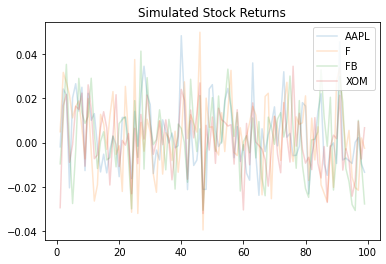

In [16]:
# plotting
column_names=['AAPL','F','FB','XOM']
R.columns = column_names

ax = R.plot(alpha=0.2, legend=False)
ax.set_title('Simulated Stock Returns', fontsize=12)
plt.legend();

In [17]:
# Part 2
N_SIM = 100  # How many simulations to run?

S_0 = prices.iloc[-1]
A = np.linalg.cholesky(cov)
S = np.zeros([noa, N])
S[:, 0] = S_0

for t in range(0, N_SIM):
    for i in range(1, N):    
        drift = (mu - 0.5 * sigma**2) * dt 
        Z = np.random.normal(0., 1., noa) 
        diffusion = np.matmul(A, Z) * np.sqrt(dt) 
        S[:, i] = S[:, i-1]*np.exp(drift + diffusion) 

        R = pd.DataFrame(S.T).pct_change().dropna()

        port_rets = np.cumprod(np.inner(weights, R) + 1)
    port_returns_all[:, t] = port_rets
    
port_returns_all = pd.DataFrame(port_returns_all)

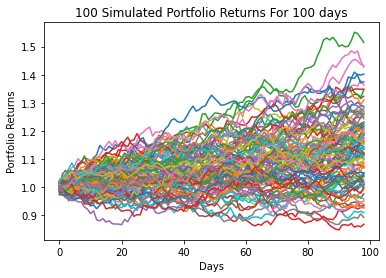

In [18]:
plt.plot(port_returns_all)
plt.ylabel('Portfolio Returns')
plt.xlabel('Days')
plt.title('100 Simulated Portfolio Returns For 100 days');

In [21]:
# Part 3

def bsm_put_value(S, K, T, r, sigma):
    
    ''' Valuation of European call option in BSM model.
    Analytical formula.
    Parameters
    ==========
    S0: float
    initial stock/index level
    K: float
    T: float
    maturity date (in year fractions)
    r: float
    constant risk-free short rate
    sigma: float
    volatility factor in diffusion term
    Returns
    =======
    value: float
    present value of the European call option
    '''
    
    from math import log, sqrt, exp
    from scipy import stats
    
    S = float(S) # This is the current stock price. float() just makes sure that it is that type of number, and not in integer.
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    # stats.norm.cdf --> cumulative distribution function
    # for normal distribution
    value = (K * exp(-r * T) * stats.norm.cdf(-d2, 0.0, 1.0) - S * stats.norm.cdf(-d1, 0.0, 1.0))
    return value

In [34]:
aapl_cov = cov.iloc[0,0]
aapl_cov

0.0002721913570065188

In [35]:
vol = np.sqrt(aapl_cov * 252)
vol

0.26190116831668153

In [37]:
bsm_put_value(158.83, 150, 42/365, 0.03, vol)

2.0127674207585358

My volatility estimate must be quite different from what the market thinks!

In [38]:
bsm_put_value(158.83, 150, 42/365, 0.03, 0.4412)

5.265408054627997

I'm using the implied volatility from Yahoo! Finance for that option. I'm within a penny of the traded option price.